In [2]:
import csv
import random
import numpy as np
from collections import Counter



In [3]:
def parse_bike_data(file_path):
    data = []
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            data.append({
                'date': row['start_date'].split()[0],
                'duration': int(row['duration']),
                'start_station_name': row['start_station_name'],
                'end_station_name': row['end_station_name']
            })
    return data



In [4]:
def parse_weather_data(file_path):
    data = {}
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            try:
                date = row['date']
                max_temp = float(row['max_temperature_f'])
                mean_temp = float(row['mean_temperature_f'])
                min_temp = float(row['min_temperature_f'])
                max_dew_point = float(row['max_dew_point_f'])
                mean_dew_point = float(row['mean_dew_point_f'])
                min_dew_point = float(row['min_dew_point_f'])
                max_humidity = float(row['max_humidity'])
                mean_humidity = float(row['mean_humidity'])
                min_humidity = float(row['min_humidity'])
                data[date] = {
                    'max_temperature_f': max_temp,
                    'mean_temperature_f': mean_temp,
                    'min_temperature_f': min_temp,
                    'max_dew_point_f': max_dew_point,
                    'mean_dew_point_f': mean_dew_point,
                    'min_dew_point_f': min_dew_point,
                    'max_humidity': max_humidity,
                    'mean_humidity': mean_humidity,
                    'min_humidity': min_humidity
                }
            except ValueError:
                continue
    return data




In [5]:

def merge_data(bike_data, weather_data):
    merged_data = []
    for entry in bike_data:
        date = entry['date']
        if date in weather_data:
            entry.update(weather_data[date])
            merged_data.append(entry)
    return merged_data

def preprocess_data(data):
    observations = []
    for entry in data:
        observation = (
            entry['max_temperature_f'],
            entry['mean_temperature_f'],
            entry['min_temperature_f'],
            entry['max_dew_point_f'],
            entry['mean_dew_point_f'],
            entry['min_dew_point_f'],
            entry['max_humidity'],
            entry['mean_humidity'],
            entry['min_humidity']
        )
        observations.append(observation)
    return observations



In [6]:
def build_hmm(data, num_states):
    state_counter = Counter(data)
    top_states = state_counter.most_common(num_states)
    state_index_map = {state: i for i, (state, _) in enumerate(top_states)}
    
    num_states = len(top_states)
    transition_matrix = np.zeros((num_states, num_states))
    
    for i in range(len(data) - 1):
        current_state = data[i]
        next_state = data[i + 1]
        if current_state in state_index_map and next_state in state_index_map:
            current_index = state_index_map[current_state]
            next_index = state_index_map[next_state]
            transition_matrix[current_index][next_index] += 1
    
    transition_matrix /= np.sum(transition_matrix, axis=1, keepdims=True)
    
    return transition_matrix, state_index_map

def viterbi(observations, transition_matrix, state_index_map):
    num_states = len(transition_matrix)
    num_observations = len(observations)
    
    V = np.zeros((num_states, num_observations))
    backtrack = np.zeros((num_states, num_observations), dtype=int)
    
    for i in range(num_states):
        V[i][0] = transition_matrix[i][state_index_map.get(observations[0], -1)]
    
    for t in range(1, num_observations):
        for s in range(num_states):
            if observations[t] in state_index_map:
                prob_transitions = [V[s_prime][t-1] * transition_matrix[s_prime][s] for s_prime in range(num_states)]
                V[s][t] = max(prob_transitions)
                backtrack[s][t] = np.argmax(prob_transitions)
    
    best_sequence = [np.argmax(V[:, num_observations - 1])]
    for t in range(num_observations - 1, 0, -1):
        best_sequence.insert(0, backtrack[best_sequence[0]][t])
    
    predicted_durations = [int(observation[-1]) for observation in observations]
    
    return predicted_durations

def calculate_accuracy(predicted_durations, actual_durations):
    absolute_errors = [abs(pred - actual) for pred, actual in zip(predicted_durations, actual_durations)]
    mean_absolute_error = np.mean(absolute_errors)
    return mean_absolute_error




In [7]:
bike_data_file = '/kaggle/input/sf-bay-area-bike-share/trip.csv'
weather_data_file = '/kaggle/input/sf-bay-area-bike-share/weather.csv'

bike_data = parse_bike_data(bike_data_file)
weather_data = parse_weather_data(weather_data_file)

merged_data = merge_data(bike_data, weather_data)
random.shuffle(merged_data)

num_states = 50 

observations = preprocess_data(merged_data)

transition_matrix, state_index_map = build_hmm(observations, num_states)

predicted_durations = viterbi(observations, transition_matrix, state_index_map)
actual_durations = [entry['duration'] for entry in merged_data]

accuracy = calculate_accuracy(predicted_durations, actual_durations)

print(f"Mean Absolute Error: {accuracy:.2f} minutes")



Mean Absolute Error: 1067.31 minutes


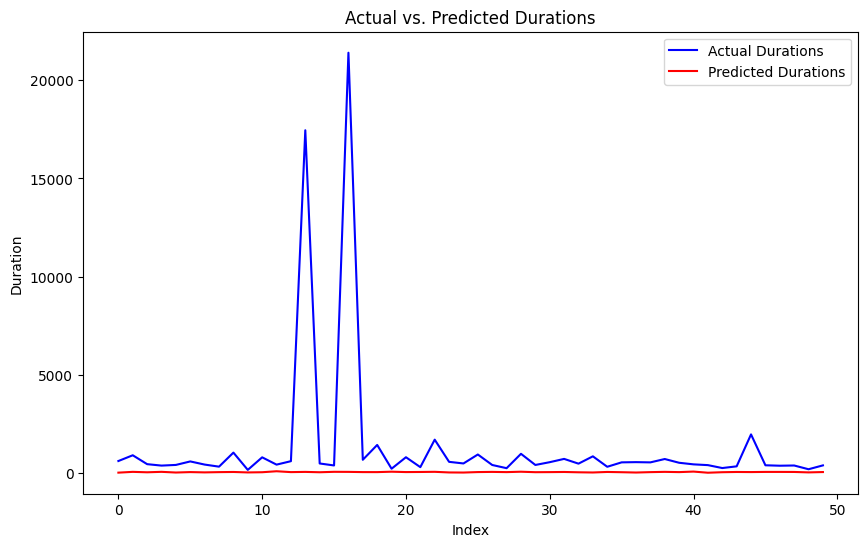

In [8]:
import csv
import numpy as np
from collections import Counter
from hmmlearn import hmm
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_durations[0:50], label='Actual Durations', color='blue')
plt.plot(predicted_durations[0:50], label='Predicted Durations', color='red')
plt.xlabel('Index')
plt.ylabel('Duration')
plt.title('Actual vs. Predicted Durations')
plt.legend()
plt.show()

In [12]:
print(predicted_durations[0:10])

[13, 53, 31, 54, 19, 41, 26, 39, 47, 24]
